# 1 .구글 드라이브와 연결

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [52]:
# koreanize-matplotlib 라이브러리 설치
!pip install koreanize-matplotlib

# matplotlib 라이브러리, matplotlib에서 한글을 사용하기 위한 라이브러리 임포트
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [53]:
# 마운트된 드라이브 경로 확인
import os
project_path = '/content/gdrive/My Drive/sw융합프로젝트(1)/'

# 해당 폴더 내 파일 목록 확인
files = os.listdir(project_path)
print(files)

['행정구역(읍면동)', '행정구역(시군구)', '인천광역시_시내버스 정류소 현황_20241231.csv', '인천광역시.geojson', '아파트(매매)_실거래가_20250512141056.csv', '연립다세대(전월세)_실거래가_20250512142423.csv', '아파트(전월세)_실거래가_20250512142547.csv', '연립다세대(매매)_실거래가_20250512142554.csv', 'apt_geocoded.csv', 'multi_geocoded.csv']


# 2. 인천 서구 정류소 현황

In [54]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium

In [58]:
import pandas as pd

# 파일 경로 설정
csv_path = '/content/gdrive/My Drive/sw융합프로젝트(1)/인천광역시_시내버스 정류소 현황_20241231.csv'

# 1. CSV 불러오기
df = pd.read_csv(csv_path, encoding='utf-8')  # 한글깨짐 방지
df.head()
# 위도 경도가 반대로 되어 있음

,기준 일자,정류소 명,정류소 번호,정류소아이디,권역,행정동 명,엑스좌표,위도,와이좌표,경도
0,2024-12-31,(구)주안2동치안센터,37302.0,163000302,미추홀구,주안2동,170842.1600,126.671236,439486.1420,37.457078
1,2024-12-31,(주)경동세라믹스,89146.0,168001146,서구,오류왕길동,166087.8384,126.616978,450837.1724,37.559186
2,2024-12-31,(주)경인양행앞,42096.0,168000096,서구,가좌1동,170343.6370,126.665414,444145.8737,37.499045
3,2024-12-31,(주)경인양행앞,42097.0,168000097,서구,석남2동,170465.3876,126.666789,444178.4131,37.499342
4,2024-12-31,(주)대한특수금속,39050.0,165000050,남동구,논현고잔동,172879.0446,126.694491,433147.5666,37.400029


In [59]:
# 위도랑 경도 제대로 고치기
df = df.rename(columns={'위도': '경도_tmp', '경도': '위도'})
df = df.rename(columns={'경도_tmp': '경도'})
df

,기준 일자,정류소 명,정류소 번호,정류소아이디,권역,행정동 명,엑스좌표,경도,와이좌표,위도
0,2024-12-31,(구)주안2동치안센터,37302.0,163000302,미추홀구,주안2동,170842.1600,126.671236,439486.1420,37.457078
1,2024-12-31,(주)경동세라믹스,89146.0,168001146,서구,오류왕길동,166087.8384,126.616978,450837.1724,37.559186
2,2024-12-31,(주)경인양행앞,42096.0,168000096,서구,가좌1동,170343.6370,126.665414,444145.8737,37.499045
3,2024-12-31,(주)경인양행앞,42097.0,168000097,서구,석남2동,170465.3876,126.666789,444178.4131,37.499342
4,2024-12-31,(주)대한특수금속,39050.0,165000050,남동구,논현고잔동,172879.0446,126.694491,433147.5666,37.400029
...,...,...,...,...,...,...,...,...,...,...
6915,2024-12-31,힐스테이트학익104동앞,37669.0,163000669,미추홀구,용현5동,168741.3734,126.647550,438140.7792,37.444887
6916,2024-12-31,힐캐슬프라자,39331.0,165000331,남동구,구월2동,174638.7810,126.714149,439413.5819,37.456536
6917,2024-12-31,힐캐슬프라자,39329.0,165000329,남동구,구월2동,174634.8498,126.714105,439385.9196,37.456287
6918,2024-12-31,힘찬병원,40892.0,166000892,부평구,부평5동,176029.5694,126.729737,443418.2177,37.492655


In [62]:
# 1. 원본에서 복사본 생성 (명시적 copy)
df = df.copy()

# 2. 권역 컬럼 공백 제거
df['권역'] = df['권역'].str.strip()

# 3. 서구만 필터링
df = df[df['권역'] == '서구'].copy()

# 4. geometry 생성 (Point(경도, 위도))
df['geometry'] = df.apply(lambda row: Point(row['위도'], row['경도']), axis=1)

# 5. GeoDataFrame 생성
gdf_seogu_bus = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

In [66]:
center_lat = gdf_seogu_bus['위도'].mean()  # 실제 위도
center_lon = gdf_seogu_bus['경도'].mean()  # 실제 경도

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

for _, row in gdf_seogu_bus.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=row['정류소 명']
    ).add_to(m)

m

In [71]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point

# 위도/경도 형변환 및 결측 제거
df['위도'] = pd.to_numeric(df['위도'], errors='coerce')
df['경도'] = pd.to_numeric(df['경도'], errors='coerce')
df = df.dropna(subset=['위도', '경도'])

# GeoDataFrame 변환 (Point(경도, 위도))
df['geometry'] = df.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
gdf_bus = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# 행정동별 정류장 수 집계
dong_counts = gdf_bus['행정동 명'].value_counts().reset_index()
dong_counts.columns = ['행정동 명', '정류장 수']

# 정류장 수 기준으로 내림차순 정렬
dong_counts = dong_counts.sort_values(by='행정동 명', ascending=True).reset_index(drop=True)
dong_counts

,행정동 명,정류장 수
0,가정1동,44
1,가정2동,11
2,가정3동,13
3,가정동,4
4,가좌1동,44
5,가좌2동,22
6,가좌3동,24
7,가좌4동,29
8,가좌동,2
9,검단1동,39


# 3. 행정동 경계 불러오기

In [76]:
# 행정동 경계 geojson 불러오기
dong_geo_path = '/content/gdrive/My Drive/sw융합프로젝트(1)/인천광역시.geojson'
gdf_dong = gpd.read_file(dong_geo_path)
gdf_dong

,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,sggnm,geometry
0,764,인천광역시 중구 연안동,2301052,2811052000,28110,28,인천광역시,중구,"MULTIPOLYGON (((126.61984 37.46191, 126.62116 ..."
1,765,인천광역시 중구 신포동,2301053,2811053000,28110,28,인천광역시,중구,"MULTIPOLYGON (((126.62263 37.47551, 126.62265 ..."
2,766,인천광역시 중구 신흥동,2301054,2811054000,28110,28,인천광역시,중구,"MULTIPOLYGON (((126.63669 37.46799, 126.63657 ..."
3,767,인천광역시 중구 도원동,2301056,2811056000,28110,28,인천광역시,중구,"MULTIPOLYGON (((126.64279 37.46849, 126.64209 ..."
4,768,인천광역시 중구 율목동,2301057,2811057000,28110,28,인천광역시,중구,"MULTIPOLYGON (((126.63919 37.47029, 126.63669 ..."
...,...,...,...,...,...,...,...,...,...
150,3452,인천광역시 중구 영종1동,2301066,2811062200,28110,28,인천광역시,중구,"MULTIPOLYGON (((126.56965 37.50834, 126.5712 3..."
151,3461,인천광역시 남동구 장수서창동,2305075,2820065000,28200,28,인천광역시,남동구,"MULTIPOLYGON (((126.76098 37.42629, 126.76146 ..."
152,3462,인천광역시 연수구 송도2동,2304066,2818583000,28185,28,인천광역시,연수구,"MULTIPOLYGON (((126.63958 37.38588, 126.62694 ..."
153,3478,인천광역시 서구 당하동,2308085,2826071000,28260,28,인천광역시,서구,"MULTIPOLYGON (((126.68843 37.5946, 126.68623 3..."


In [81]:
# '서구'만 필터링
gdf_dong = gdf_dong[gdf_dong['sggnm'].str.strip() == '서구'].copy()

# 'adm_nm'에서 마지막 단어(행정동 명)만 추출
gdf_dong['행정동 명'] = gdf_dong['adm_nm'].str.strip().apply(lambda x: x.split()[-1])

# 행정동 명 목록 출력 (중복 제거 및 정렬)
dong_names = sorted(gdf_dong['행정동 명'].unique())
dong_df = pd.DataFrame(dong_names, columns=['행정동 명'])
dong_df

,행정동 명
0,가정1동
1,가정2동
2,가정3동
3,가좌1동
4,가좌2동
5,가좌3동
6,가좌4동
7,검단동
8,검암경서동
9,당하동


In [11]:
print(gdf_bus.crs)
print(gdf_dong.crs)

EPSG:4326
EPSG:4326


# ISSUE 1. 버스 정류장이 실제로 존재하는 행정동이 서구 전체 행정동 개수 보다 많음 (각각 40개, 22개)
- dong_counts에는 버스 정류장이 실제로 존재하는 행정동,
dong_df에는 서구 전체 행정동 목록이 담겨 있음
- dong_counts에만 존재하는 추가 행정동들을 찾기 위해선 set 차집합을 사용

In [83]:
# 이름 집합 만들기
dong_counts_names = set(dong_counts['행정동 명'].unique())
dong_df_names = set(dong_df['행정동 명'].unique())

# 차집합 계산
only_in_counts = sorted(dong_counts_names - dong_df_names)
only_in_geojson = sorted(dong_df_names - dong_counts_names)

# 최대 길이에 맞춰 길이 맞추기
max_len = max(len(only_in_counts), len(only_in_geojson))
only_in_counts += [''] * (max_len - len(only_in_counts))
only_in_geojson += [''] * (max_len - len(only_in_geojson))

# 비교용 DataFrame 생성
comparison_df = pd.DataFrame({
    'dong_counts에만 있음': only_in_counts,
    'geojson에만 있음': only_in_geojson
})

# 출력
comparison_df

,dong_counts에만 있음,geojson에만 있음
0,가정동,
1,가좌동,
2,검단1동,
3,검단2동,
4,검단3동,
5,검암동,
6,경서동,
7,금곡동,
8,대곡동,
9,백석동,


In [ ]:
# "원찬동"은 "원창동의 오타인 것으로 보임"
# http://www.seniortoday.co.kr/news/articleView.html?idxno=3985

In [42]:
# 좌표계 지정 (EPSG:4326은 위도-경도 좌표계)
gdf_seogu_bus.set_crs(epsg=4326, inplace=True)

# 위도, 경도 순서가 아니라 → 경도, 위도 순서로 입력해야 함
df['geometry'] = df.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
gdf_seogu_bus = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
gdf_seogu_bus['geometry'] = gdf_seogu_bus.apply(lambda row: Point(row['경도'], row['위도']), axis=1)

# 올바르게 geometry 재생성
gdf_seogu_bus['geometry'] = gdf_seogu_bus.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
gdf_seogu_bus.set_crs(epsg=4326, inplace=True)
gdf_seogu_bus

,기준 일자,정류소 명,정류소 번호,정류소아이디,권역,행정동 명,엑스좌표,위도,와이좌표,경도,geometry
1,2024-12-31,(주)경동세라믹스,89146.0,168001146,서구,오류왕길동,166087.8384,126.616978,450837.1724,37.559186,POINT (37.55919 126.61698)
2,2024-12-31,(주)경인양행앞,42096.0,168000096,서구,가좌1동,170343.6370,126.665414,444145.8737,37.499045,POINT (37.49905 126.66541)
3,2024-12-31,(주)경인양행앞,42097.0,168000097,서구,석남2동,170465.3876,126.666789,444178.4131,37.499342,POINT (37.49934 126.66679)
8,2024-12-31,(주)스킨이데아,89388.0,168001388,서구,원찬동,166105.6856,126.617473,444479.2189,37.501903,POINT (37.5019 126.61747)
9,2024-12-31,(주)스킨이데아,89389.0,168001389,서구,원창동,166107.5171,126.617495,444459.0933,37.501721,POINT (37.50172 126.6175)
...,...,...,...,...,...,...,...,...,...,...,...
6856,2024-12-31,효성아파트,42168.0,168000168,서구,석남1동,170282.1244,126.664651,445792.3371,37.513878,POINT (37.51388 126.66465)
6876,2024-12-31,휴먼시아후문,42885.0,168000885,서구,청라2동,168749.6769,126.647243,447554.8589,37.529707,POINT (37.52971 126.64724)
6891,2024-12-31,희성금속,42018.0,168000018,서구,가좌3동,171276.1861,126.676031,442303.9651,37.482480,POINT (37.48248 126.67603)
6892,2024-12-31,힐데스하임,42876.0,168000876,서구,청라1동,169240.1662,126.652792,447562.8537,37.529796,POINT (37.5298 126.65279)


In [43]:
df

,기준 일자,정류소 명,정류소 번호,정류소아이디,권역,행정동 명,엑스좌표,위도,와이좌표,경도,geometry
1,2024-12-31,(주)경동세라믹스,89146.0,168001146,서구,오류왕길동,166087.8384,126.616978,450837.1724,37.559186,POINT (37.55918552 126.6169776)
2,2024-12-31,(주)경인양행앞,42096.0,168000096,서구,가좌1동,170343.6370,126.665414,444145.8737,37.499045,POINT (37.49904538 126.6654136)
3,2024-12-31,(주)경인양행앞,42097.0,168000097,서구,석남2동,170465.3876,126.666789,444178.4131,37.499342,POINT (37.49934246 126.6667891)
8,2024-12-31,(주)스킨이데아,89388.0,168001388,서구,원찬동,166105.6856,126.617473,444479.2189,37.501903,POINT (37.50190268 126.6174734)
9,2024-12-31,(주)스킨이데아,89389.0,168001389,서구,원창동,166107.5171,126.617495,444459.0933,37.501721,POINT (37.50172142 126.617495)
...,...,...,...,...,...,...,...,...,...,...,...
6856,2024-12-31,효성아파트,42168.0,168000168,서구,석남1동,170282.1244,126.664651,445792.3371,37.513878,POINT (37.51387774 126.6646513)
6876,2024-12-31,휴먼시아후문,42885.0,168000885,서구,청라2동,168749.6769,126.647243,447554.8589,37.529707,POINT (37.52970697 126.6472431)
6891,2024-12-31,희성금속,42018.0,168000018,서구,가좌3동,171276.1861,126.676031,442303.9651,37.482480,POINT (37.48247958 126.6760314)
6892,2024-12-31,힐데스하임,42876.0,168000876,서구,청라1동,169240.1662,126.652792,447562.8537,37.529796,POINT (37.52979552 126.6527918)


In [12]:
gdf_dong = gdf_dong[gdf_dong['sggnm'] == '서구'].copy()

In [23]:
# 먼저 '행정동 명' 컬럼 생성
gdf_dong['행정동 명'] = gdf_dong['adm_nm'].apply(lambda x: x.strip().split()[-1])
print("---행정동 명---")
print(gdf_dong['행정동 명'].unique())

# 이후에 sjoin 수행
gdf_bus = gdf_bus.to_crs(gdf_dong.crs)  # 좌표계 일치 필수
gdf_joined = gpd.sjoin(gdf_bus, gdf_dong[['행정동 명', 'geometry']], how='left', predicate='within')

print("---행정동 명_left---")
print(gdf_joined['행정동 명_left'].unique())

---행정동 명---
['검암경서동' '연희동' '가정1동' '가정2동' '가정3동' '석남1동' '석남2동' '석남3동' '가좌1동' '가좌2동'
 '가좌3동' '가좌4동' '불로대곡동' '원당동' '마전동' '신현원창동' '청라1동' '청라2동' '검단동' '오류왕길동'
 '청라3동' '당하동']
---행정동 명_left---
['오류왕길동' '가좌1동' '석남2동' '원찬동' '원창동' '검단1동' '신현원창동' '불로대곡동' '원당동' '오류동'
 '당하동' '연희동' '검암경서동' '청라3동' '석남1동' '가정동' '가좌2동' '가정1동' '가좌4동' '가좌3동'
 '가정3동' '석남3동' '청라동' '가좌동' '마전동' '아라동' '대곡동' '청라2동' '검암동' '심곡동' '금곡동'
 '백석동' '가정2동' '청라1동' '검단동' '불로동' '송림4동' '검단2동' '검단3동' '경서동']


In [24]:
sorted_dongs = sorted(gdf_dong['행정동 명'].unique())
print("--- 행정구역 데이터의 행정동 명 (가나다순)---")
print(sorted_dongs)

sorted_dongs_left = sorted(gdf_joined['행정동 명_left'].unique())
print("---버스 정류장 위치의 행정동 명_left (가나다순)---")
print(sorted_dongs_left)

--- 행정구역 데이터의 행정동 명 (가나다순)---
['가정1동', '가정2동', '가정3동', '가좌1동', '가좌2동', '가좌3동', '가좌4동', '검단동', '검암경서동', '당하동', '마전동', '불로대곡동', '석남1동', '석남2동', '석남3동', '신현원창동', '연희동', '오류왕길동', '원당동', '청라1동', '청라2동', '청라3동']
---버스 정류장 위치의 행정동 명_left (가나다순)---
['가정1동', '가정2동', '가정3동', '가정동', '가좌1동', '가좌2동', '가좌3동', '가좌4동', '가좌동', '검단1동', '검단2동', '검단3동', '검단동', '검암경서동', '검암동', '경서동', '금곡동', '당하동', '대곡동', '마전동', '백석동', '불로대곡동', '불로동', '석남1동', '석남2동', '석남3동', '송림4동', '신현원창동', '심곡동', '아라동', '연희동', '오류동', '오류왕길동', '원당동', '원찬동', '원창동', '청라1동', '청라2동', '청라3동', '청라동']


In [25]:
# sjoin 결과에서 실제 매칭된 것들만 필터링
matched = gdf_joined[~gdf_joined['index_right'].isna()]

# 총 정류장 수 vs 매칭된 정류장 수 비교
total = len(gdf_joined)
matched_count = len(matched)
unmatched_count = total - matched_count

print(f"전체 정류장 수: {total}")
print(f"매칭된 정류장 수: {matched_count}")
print(f"매칭 실패 수: {unmatched_count}")
print(f"매칭률: {matched_count / total:.2%}")

전체 정류장 수: 1085
매칭된 정류장 수: 0
매칭 실패 수: 1085
매칭률: 0.00%


In [26]:
# 어떤 행정동 명(=left 기준)에서 매칭이 많이 되었는지 확인
gdf_joined['행정동 명_left'].value_counts().head(10)

,count
행정동 명_left,
청라3동,97
오류왕길동,95
검암경서동,91
아라동,68
연희동,65
청라2동,62
신현원창동,61
청라1동,49
가정1동,44


In [27]:
dong_counts = gdf_joined['행정동 명_left'].value_counts().reset_index()
dong_counts.columns = ['행정동 명', '정류장 수']


# 7. 병합
gdf_merge = gdf_dong.merge(dong_counts, on='행정동 명', how='left')
gdf_merge['정류장 수'] = gdf_merge['정류장 수'].fillna(0).astype(int)

# 8. 지도 생성
m = folium.Map(location=[37.545, 126.675], zoom_start=13)

# 9. Choropleth 층 만들기
folium.Choropleth(
    geo_data=gdf_merge.to_json(),
    name='정류장 밀집도',
    data=gdf_merge,
    columns=['adm_nm', '정류장 수'],
    key_on='feature.properties.adm_nm',
    fill_color='YlGnBu',  # 색상 팔레트 변경
    fill_opacity=0.7,
    line_opacity=0.4,
    line_color='white',
    legend_name='행정동별 버스 정류장 수',
    highlight=True
).add_to(m)

# 10. 행정동 이름 툴팁 추가
folium.GeoJson(
    gdf_merge,
    name="행정동 경계",
    tooltip=folium.GeoJsonTooltip(
        fields=["adm_nm", "정류장 수"],
        aliases=["행정동", "정류장 수"],
        localize=True
    ),
    style_function=lambda x: {
        "fillOpacity": 0,
        "color": "gray",
        "weight": 1
    }
).add_to(m)

# 11. 지도 저장 및 출력
m.save('서구_버스정류장_밀집도_지도.html')
m

In [28]:
gdf_dong.head()

,OBJECTID,adm_nm,adm_cd,adm_cd2,sgg,sido,sidonm,sggnm,geometry,행정동 명
109,873,인천광역시 서구 검암경서동,2308051,2826051500,28260,28,인천광역시,서구,"MULTIPOLYGON (((126.56832 37.57282, 126.56843 ...",검암경서동
110,874,인천광역시 서구 연희동,2308053,2826053000,28260,28,인천광역시,서구,"MULTIPOLYGON (((126.69951 37.55889, 126.69968 ...",연희동
111,875,인천광역시 서구 가정1동,2308054,2826054200,28260,28,인천광역시,서구,"MULTIPOLYGON (((126.67652 37.53853, 126.67659 ...",가정1동
112,876,인천광역시 서구 가정2동,2308055,2826054300,28260,28,인천광역시,서구,"MULTIPOLYGON (((126.68361 37.5352, 126.6837 37...",가정2동
113,877,인천광역시 서구 가정3동,2308056,2826054400,28260,28,인천광역시,서구,"MULTIPOLYGON (((126.68328 37.51466, 126.68035 ...",가정3동


In [29]:
import branca.colormap as cm
import folium
import io
from PIL import Image
import time

# 1. 정류장 수의 최대/최소를 기준으로 colormap 생성
min_val = gdf_merge['정류장 수'].min()
max_val = gdf_merge['정류장 수'].max()
colormap = cm.linear.YlGnBu_09.scale(min_val, max_val)
colormap.caption = '행정동별 버스 정류장 수'

# 2. 지도 생성
m = folium.Map(location=[37.545, 126.675], zoom_start=13)

# 3. Choropleth 수동 스타일 매핑 (→ 진하기 강조!)
folium.GeoJson(
    gdf_merge,
    name="정류장 밀집도",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['정류장 수']),
        'color': 'white',
        'weight': 1,
        'fillOpacity': 0.8,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["adm_nm", "정류장 수"],
        aliases=["행정동", "정류장 수"],
        localize=True
    )
).add_to(m)

# 4. 컬러바(범례) 추가
colormap.add_to(m)

# 5. 지도 출력
m


In [34]:
# geometry가 유효한지 확인
print(gdf_seogu_bus.geometry.is_valid.value_counts())
print(gdf_seogu_bus.geometry.isna().sum())

# 유효한 geometry만 남기기
gdf_seogu_bus = gdf_seogu_bus[gdf_seogu_bus.geometry.notnull() & gdf_seogu_bus.geometry.is_valid]

True    1085
Name: count, dtype: int64
0


ValueError: aspect must be finite and positive 

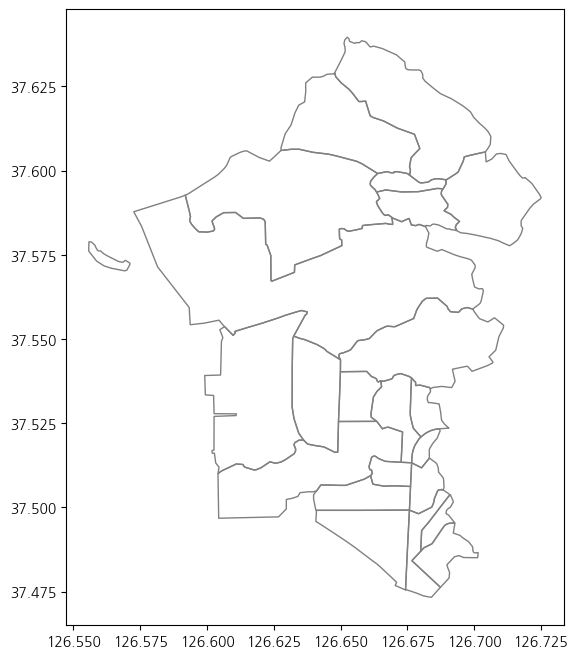

In [44]:
import matplotlib.pyplot as plt

# 좌표계 누락 방지
gdf_seogu_bus.set_crs(epsg=4326, inplace=True)

# 시각화
fig, ax = plt.subplots(figsize=(8, 8))
gdf_dong.boundary.plot(ax=ax, color='gray', linewidth=1)
gdf_seogu_bus.plot(ax=ax, color='red', markersize=3)
plt.title("서구 경계 내 정류장 분포")
plt.show()